# Preprocessing

In [ ]:
#rfm.head().style.set_table_attributes('style="font-size: 20px"')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pandas.plotting import parallel_coordinates
import matplotlib as mpl
import calendar
%matplotlib inline
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [2]:
retail = pd.read_csv('retail_clean.csv')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [132]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 9 columns):
InvoiceNo      397924 non-null int64
StockCode      397924 non-null object
Description    397924 non-null object
Quantity       397924 non-null int64
InvoiceDate    397924 non-null datetime64[ns]
UnitPrice      397924 non-null float64
CustomerID     397924 non-null int64
Country        397924 non-null object
revenue        397924 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 27.3+ MB


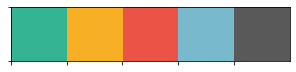

In [4]:
color_dict = {'g':'#35b494', 'y': '#f7b025', 'r':'#ea5345', 'b':'#79b9ce', 'title':'#595959'}
params = {i:color_dict['title'] for i in ["ytick.color", "xtick.color","axes.labelcolor","text.color"]}
#clusters_palette = ['#f7b025','lightcoral', '#35b494', '#79b9ce', 'silver']
sns.palplot(color_dict.values())

# RFM Analysis

In [5]:
# Compute RFM
today = pd.to_datetime('2011-12-10', format='%Y-%m-%d')
rfm = (retail.groupby('CustomerID')
       .agg({'InvoiceDate': {
                 'lifetime':lambda x: (x.max() - x.min()).days,
                 'recency': lambda x: (x.max() - today).days
                            },
             'InvoiceNo': {'frequency': pd.Series.nunique},
             'revenue': {'monetary': 'sum'}}))
rfm.columns = rfm.columns.droplevel()
rfm.head()

,lifetime,recency,frequency,monetary
CustomerID,,,,
12346,0,-326,1,77183.60
12347,365,-3,7,4310.00
12348,282,-76,4,1797.24
12349,0,-19,1,1757.55
12350,0,-311,1,334.40


In [6]:
rfm.describe().round()

,lifetime,recency,frequency,monetary
count,4339.0,4339.0,4339.0,4339.0
mean,130.0,-93.0,4.0,2054.0
std,132.0,100.0,8.0,8988.0
min,0.0,-374.0,1.0,0.0
25%,0.0,-142.0,1.0,307.0
50%,92.0,-51.0,2.0,674.0
75%,252.0,-18.0,5.0,1662.0
max,373.0,-1.0,210.0,280206.0


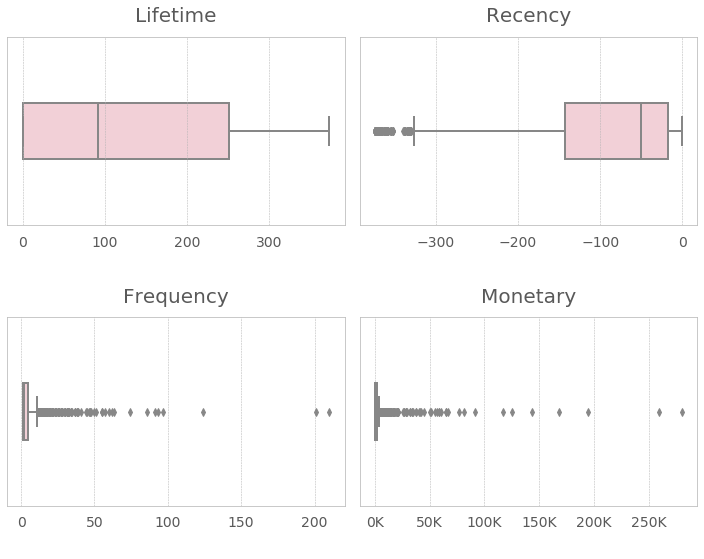

In [7]:
plt.style.use('bmh')
mpl.rcParams['axes.facecolor'] = 'white'
plt.rc('font', **{'size'   : 14})
plt.rcParams.update(params)

fig, ax = plt.subplots(2,2, figsize=[10, 8], dpi=72)
col_idx = 0

for i in range(2):
    for j in range(2):
        sns.boxplot(rfm.iloc[:, col_idx], ax=ax[i,j], color='#f8cad4', width=0.3)
        ax[i,j].set_xlabel('123', color='white')
        ax[i,j].set_title(rfm.columns[col_idx].capitalize(), fontsize=20, color=color_dict['title'], y=1.05)
        ax[i,j].tick_params(axis='both', which='both', length=0, pad=10)
        col_idx += 1

ax[1,1].set_xticklabels([str(i)+'K' for i in np.arange(-50,251,50)])        
        
plt.tight_layout()
plt.savefig('Boxplots of RFM', facecolor='white', bbox_inches="tight", dpi=75)

<Figure size 432x288 with 0 Axes>

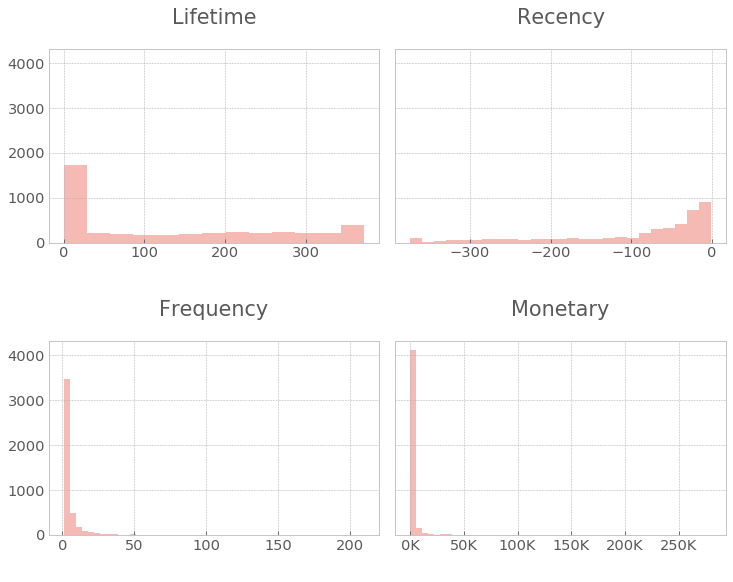

In [8]:
plt.style.use('bmh')
mpl.rcParams['axes.facecolor'] = 'white'
plt.rc('font', **{'size'   : 14})
plt.rcParams.update(params)
plt.subplots_adjust(hspace=1)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8], dpi=75, sharey=True)
col_idx = 0

for i in range(2):
    for j in range(2):
        sns.distplot(rfm.iloc[:, col_idx], ax=ax[i,j], color=color_dict['r'], kde=False, norm_hist=False)
        ax[i,j].tick_params(axis='y', which='both', length=0)
        ax[i,j].set_xlabel('123', color='white')
        ax[i,j].set_title(rfm.columns[col_idx].capitalize(), fontsize=20, color=color_dict['title'], y=1.1)
        ax[i,j].set_yticks(np.arange(0,5000,1000))
#        ax[i,j].set_yticklabels([str(i)+'K' for i in np.arange(0,5)])
        col_idx += 1

ax[1,1].set_xticklabels([str(i)+'K' for i in np.arange(-50,251,50)])

#fig.suptitle('Distributions Before Removing Outliers', fontsize=20, color='#595959', y=1.05)
plt.tight_layout()    
plt.savefig('Distribution of RFM before removing outliers', facecolor='white', bbox_inches="tight", dpi=75)

# Removing Outliers

In [155]:
col_selected = ['frequency','monetary']
outlier_filter = ((rfm[col_selected] > rfm[col_selected].std()*4) | (rfm[col_selected] < rfm[col_selected].std()*(-4))).sum(axis=1) == 0
rfm_clean = rfm.loc[outlier_filter.values]
print('removed '+ str(len(rfm)-len(rfm_clean)) +' outliers')

removed 52 outliers


<Figure size 432x288 with 0 Axes>

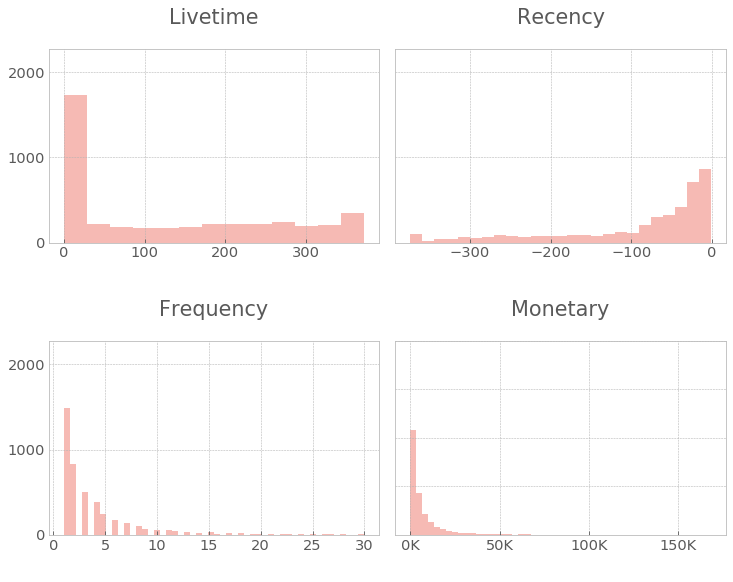

In [64]:
plt.style.use('bmh')
mpl.rcParams['axes.facecolor'] = 'white'
plt.rc('font', **{'size'   : 14})
plt.rcParams.update(params)
plt.subplots_adjust(hspace=1)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8], dpi=75, sharey=True)
col_idx = 0

for i in range(2):
    for j in range(2):
        sns.distplot(rfm_clean.iloc[:, col_idx], ax=ax[i,j], color=color_dict['r'], kde=False, norm_hist=False)
        ax[i,j].tick_params(axis='y', which='both', length=0)
        ax[i,j].set_xlabel('123', color='white')
        ax[i,j].set_title(rfm_clean.columns[col_idx].capitalize(), fontsize=20, color=color_dict['title'], y=1.1)
        ax[i,j].set_yticks(np.arange(0,5000,1000))
        col_idx += 1
    
ax[1,1].set_xticklabels([str(i)+'K' for i in np.arange(-50,251,50)])

#fig.suptitle('Distributions After Removing Outliers', fontsize=20, color='#595959', y=1.1)
plt.tight_layout()    
plt.savefig('Distribution of RFM after removing outliers', facecolor='white', bbox_inches="tight", dpi=75)

# Clustering

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
rfm_scaled = StandardScaler().fit_transform(rfm_clean.iloc[: , :4])

In [157]:
plt.style.use('bmh')
def find_best_k(x, kmax=10):
    wss = []
    sil = []
    for k in range(2, kmax+1):
        km = KMeans(n_clusters = k,
                        n_init=10, max_iter=300,
                        tol=1e-04, random_state=0)
        km.fit(x)
        sil.append(silhouette_score(x, km.labels_, metric = 'euclidean'))
        wss.append(km.inertia_)
    fig, ax = plt.subplots(nrows=2, figsize=[10, 8])
    sns.lineplot(x=np.arange(2,11), y=wss, ax=ax[0], color='#35b494')
    ax[0].set_xlabel('')
    ax[0].set_ylabel('WSS')
    ax[0].set_title('Finding the Best Number of Clusters', fontsize=16, y=1.05, color='#595959')
    sns.lineplot(x=np.arange(2,11), y=sil, ax=ax[1], color='#41b0e5')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Score') 
#    ax[1].grid(color='lightgrey', which='major', axis='both', linewidth=0.3)

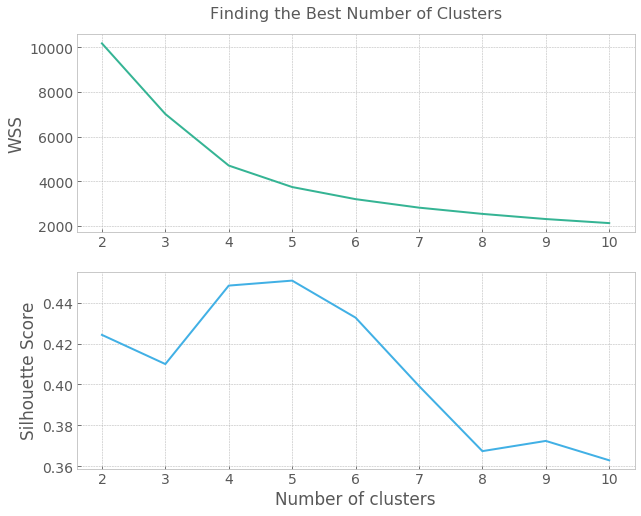

In [102]:
mpl.rcParams['axes.facecolor'] = 'white'
find_best_k(rfm_scaled)
plt.savefig('The best k for clustering', facecolor='white', bbox_inches="tight", dpi=80)

#### PCA for visualization

In [141]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [158]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
rfm_pc = pca.fit_transform(rfm_scaled)
rfm_clean['pc 1'], rfm_clean['pc 2'] = rfm_pc[:,0], rfm_pc[:,1]

In [159]:
# Choose 5 as the optimal value of k
km = KMeans(n_clusters = 5,
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0)
km.fit(rfm_scaled)
rfm_clean['km_cluster'] = km.labels_

# Differentiate 5 clusters through calculating the average value for each feature
rfm_cluster_mean = rfm_clean.groupby('km_cluster').agg({'recency':{'count':'count', 'recency':'mean'},
                                                        'lifetime':{'lifetime':'mean'},
                                                        'frequency':{'frequency':'mean'},
                                                        'monetary': {'monetary':'mean'}})
rfm_cluster_mean.columns = rfm_cluster_mean.columns.droplevel()

# Rank clusters
rfm_cluster_mean['rank'] = rfm_cluster_mean.iloc[:,1:].rank().sum(axis=1).rank(ascending=False).astype('int').astype('str')

rfm_clean['rank'] = 999

for label in range(5):
    rfm_clean.loc[rfm_clean['km_cluster'] == label, 'rank'] = rfm_cluster_mean.loc[label,'rank']
#rfm_cluster_mean = rfm_cluster_mean.sort_values('rank').reset_index(drop=True)
rfm_cluster_mean

,count,recency,lifetime,frequency,monetary,rank
km_cluster,,,,,,
0,1500,-55.682667,32.086667,1.765333,620.765055,4
1,363,-20.418733,313.911846,12.950413,5093.396694,2
2,977,-256.880246,21.014330,1.440123,437.306675,5
3,1400,-42.748571,250.441429,4.520000,1538.720836,3
4,47,-11.297872,339.765957,19.553191,16986.470213,1


In [176]:
rfm_scaled_mean = pd.DataFrame(rfm_scaled, columns=rfm.columns)
rfm_scaled_mean['km_cluster'] = km.labels_
rfm_scaled_mean = rfm_scaled_mean.groupby('km_cluster').mean()
rfm_scaled_mean['rank'] = rfm_cluster_mean['rank'].sort_index()
rfm_scaled_mean = rfm_scaled_mean.sort_values('rank').reset_index(drop=True)
rfm_scaled_mean

,lifetime,recency,frequency,monetary,rank
0,1.619534,0.825516,3.855964,6.528326,1
1,1.421707,0.734295,2.246632,1.535151,2
2,0.936054,0.510968,0.191841,0.042760,3
3,-0.734720,0.381611,-0.479569,-0.342634,4
4,-0.819441,-1.630624,-0.558835,-0.419657,5


In [ ]:
plt.style.use('bmh')
mpl.rcParams['axes.facecolor'] = 'white'
plt.rc('font', **{'size'   : 14})
plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=[10,6], dpi=75)
plt.gcf().subplots_adjust(bottom=0.3)


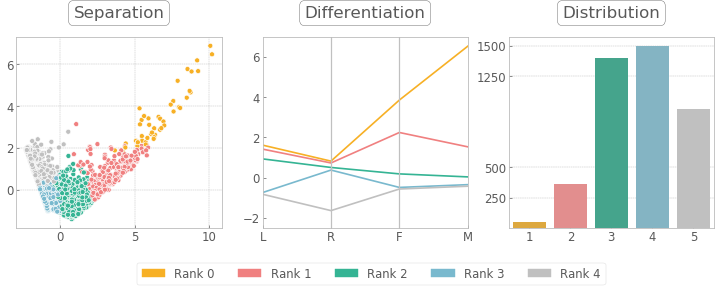

In [177]:
plt.style.use('bmh')
mpl.rcParams['axes.facecolor'] = 'white'
plt.rc('font', **{'size'   : 14})
plt.rcParams.update(params)
fig, ax = plt.subplots(ncols=3, figsize=[15,5.5], dpi=60)
plt.gcf().subplots_adjust(bottom=0.3)
#plt.subplots_adjust(wspace=0.5)

sns.scatterplot(x='pc 1', y='pc 2', hue='rank', data=rfm_clean, palette=clusters_palette, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].legend().remove()
#ax[0].yaxis.set_ticks_position('right')

parallel_coordinates(rfm_scaled_mean, 'rank', color= clusters_palette, ax=ax[1], axvlines=False)
ax[1].set_xticklabels(['L','R','F','M'])
ax[1].set_ylim(-2.5,7)
ax[1].set_ylabel('')
ax[1].legend().remove()
ax[1].axvline(x=1, linewidth=1.5, color='silver')
ax[1].axvline(x=2, linewidth=1.5, color='silver')
#ax[1].yaxis.set_ticks_position('right')

sns.countplot(rfm_clean['rank'], palette=clusters_palette, ax=ax[2])
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].set_yticks([250,500,1250,1500])
#ax[2].set_yticklabels([''] + [ str(i) + 'K' for i in np.arange(0.5,1.5, 0.5)])
#ax[2].yaxis.set_ticks_position('right')

for col, text in enumerate(['Separation', 'Differentiation', 'Distribution']):
   # ax[col].set_xlabel(text, labelpad=15)
    pos_x = ax[col].get_xlim()[1] - (ax[col].get_xlim()[1]-ax[col].get_xlim()[0])*0.5
    pos_y = ax[col].get_ylim()[1] + (ax[col].get_ylim()[1]-ax[col].get_ylim()[0])*0.1
    ax[col].text(pos_x, pos_y, text, color=color_dict['title'], fontsize=20,
                 bbox=dict(facecolor='none', edgecolor=color_dict['title'], boxstyle='round'), ha='center')
    
patches = [mpatches.Patch(color=color, label='Rank '+str(index+1)) for index, color in enumerate(clusters_palette)]
plt.legend(handles = patches, bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=14)

#fig.suptitle('Results of Clustering When K=5', fontsize=16, color='#595959', y=1.09, x=0.52)
#plt.tight_layout()
plt.savefig('Summary of Clusters When K=5 (65dpi)', facecolor='white', bbox_inches="tight", dpi=65)

In [162]:
rfm_cluster_mean.reset_index(drop=True).set_index('rank').sort_index().round().style.set_table_attributes('style="font-size: 20px"')

,count,recency,lifetime,frequency,monetary
rank,,,,,
1,47,-11,340,20,16986
2,363,-20,314,13,5093
3,1400,-43,250,5,1539
4,1500,-56,32,2,621
5,977,-257,21,1,437


In [186]:
def cluster_plot(x, y, hue, palette):
    plt.style.use('ggplot')
    plt.figure(facecolor='white', figsize=[10,6], dpi=80)
    mpl.rcParams['axes.facecolor'] = 'white'
    plt.rc('font', **{'size'   : 14})
    plt.rcParams.update(params)

    g = sns.scatterplot(x=x, y=y, hue=hue, data=rfm_clean, palette=palette, s=60, alpha=0.7)
    g.set_facecolor('white')
    g.set_xlabel(x.capitalize(), labelpad=15)
    g.set_ylabel(y.capitalize(), labelpad=15)
    g.grid(color='lightgrey', which='major', axis='both', linewidth=0.3)
    g.set_title(x.capitalize()+ ' vs. ' + y.capitalize(), fontsize=20, y=1.05, color='#595959')
    plt.legend(bbox_to_anchor=(1.15, 1.03))

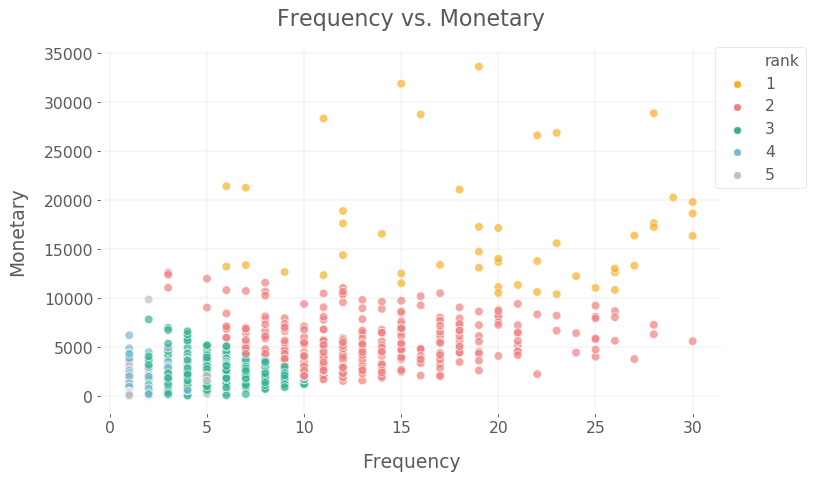

In [187]:
cluster_plot('frequency', 'monetary', 'rank', clusters_palette)
plt.savefig('Clusters- Frequency vs Monetary', facecolor='white', bbox_inches="tight", dpi=75)

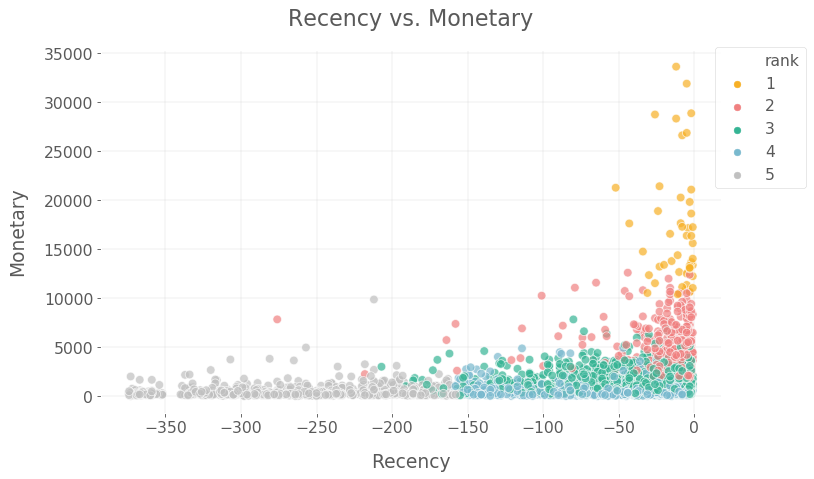

In [188]:
cluster_plot('recency', 'monetary', 'rank', clusters_palette)
plt.savefig('Clusters- Recency vs Monetary', facecolor='white', bbox_inches="tight", dpi=75)

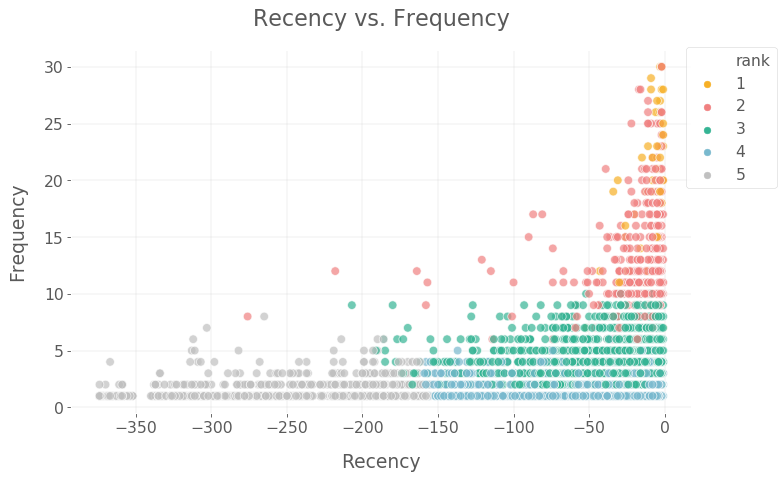

In [195]:
cluster_plot('recency', 'frequency', 'rank', clusters_palette)
plt.savefig('Clusters- Recency vs Frequency', facecolor='white', bbox_inches="tight", dpi=75)

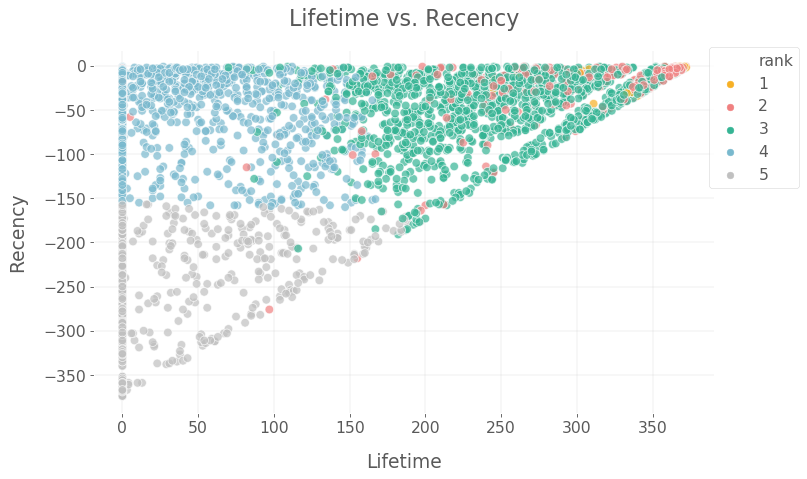

In [190]:
cluster_plot('lifetime', 'recency', 'rank', clusters_palette)
plt.savefig('Clusters- Recency vs Lifetime', facecolor='white', bbox_inches="tight", dpi=75)

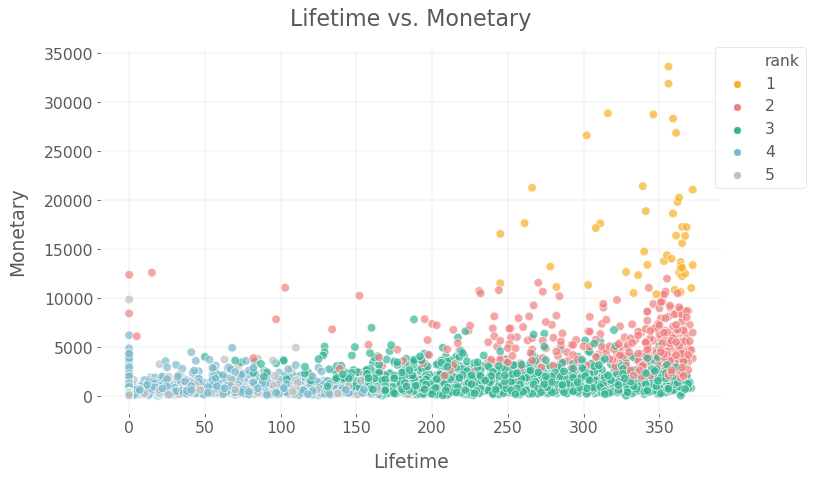

In [191]:
cluster_plot('lifetime', 'monetary', 'rank', clusters_palette)
plt.savefig('Clusters- Recency vs Lifetime', facecolor='white', bbox_inches="tight", dpi=75)

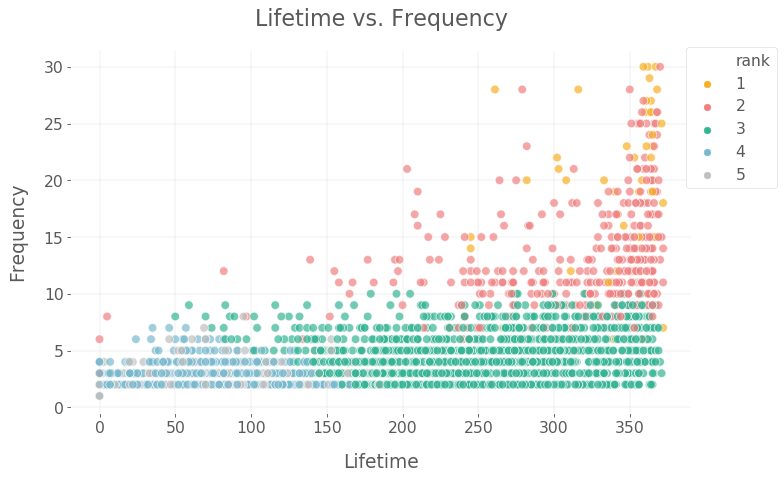

In [194]:
cluster_plot('lifetime', 'frequency', 'rank', clusters_palette)
plt.savefig('Clusters- Lifetime vs Frequency', facecolor='white', bbox_inches="tight", dpi=75)

In [172]:
rfm_clean.head()

,lifetime,recency,frequency,monetary,pc 1,pc 2,km_cluster,rank
CustomerID,,,,,,,,
12347,365,-3,7,4310.00,2.366481,-0.210402,1,2
12348,282,-76,4,1797.24,0.805095,-0.254544,3,3
12349,0,-19,1,1757.55,-0.527350,-0.546111,0,4
12350,0,-311,1,334.40,-1.985190,1.482313,2,5
12352,260,-37,8,2506.04,1.566287,-0.109669,3,3


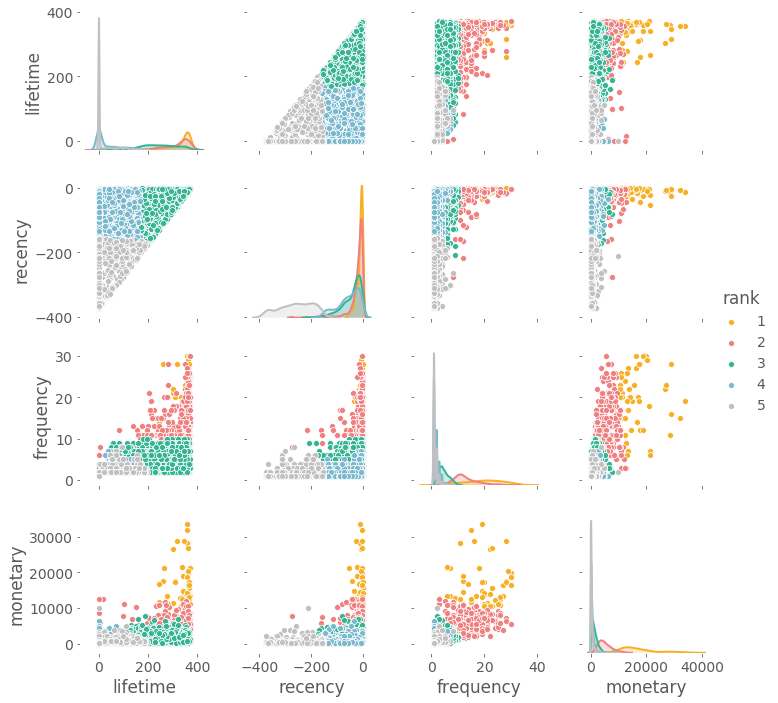

In [173]:
g = sns.pairplot(rfm_clean.iloc[:,[0,1,2,3,7]], vars=rfm_clean.columns[:4], hue='rank', palette=clusters_palette)
#for i, j in zip(*np.triu_indices_from(g.axes, 1)):
 #   g.axes[i, j].set_visible(False)

In [226]:
retail_items.head()

Description            4 PURPLE FLOCK DINNER CANDLES  \
CustomerID InvoiceNo                                   
12346.0    541431                                0.0   
           C541433                               0.0   
12347.0    537626                                0.0   
           542237                                0.0   
           549222                                0.0   

Description            50'S CHRISTMAS GIFT BAG LARGE   DOLLY GIRL BEAKER  \
CustomerID InvoiceNo                                                       
12346.0    541431                                0.0                 0.0   
           C541433                               0.0                 0.0   
12347.0    537626                                0.0                 0.0   
           542237                                0.0                 0.0   
           549222                                0.0                 0.0   

Description            I LOVE LONDON MINI BACKPACK  \
CustomerID InvoiceNo                                 
12346.0    541431                              0.0   
           C541433                             0.0   
12347.0    537626                              0.0   
           542237                              0.0   
           549222                              0.0   

Description            I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY  \
CustomerID InvoiceNo                                                           
12346.0    541431                              0.0                       0.0   
           C541433                             0.0                       0.0   
12347.0    537626                              0.0                       0.0   
           542237                              0.0                       0.0   
           549222                              0.0                       0.0   

Description            OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
CustomerID InvoiceNo                                                          
12346.0    541431                             0.0                       0.0   
           C541433                            0.0                       0.0   
12347.0    537626                             0.0                       0.0   
           542237                             0.0                       0.0   
           549222                             0.0                       0.0   

Description            SET 2 TEA TOWELS I LOVE LONDON   \
CustomerID InvoiceNo                                     
12346.0    541431                                  0.0   
           C541433                                 0.0   
12347.0    537626                                  0.0   
           542237                                  0.0   
           549222                                  0.0   

Description            SPACEBOY BABY GIFT SET  ...  ZINC STAR T-LIGHT HOLDER   \
CustomerID InvoiceNo                           ...                              
12346.0    541431                         0.0  ...                        0.0   
           C541433                        0.0  ...                        0.0   
12347.0    537626                         0.0  ...                        0.0   
           542237                         0.0  ...                        0.0   
           549222                         0.0  ...                        0.0   

Description           ZINC SWEETHEART SOAP DISH  \
CustomerID InvoiceNo                              
12346.0    541431                           0.0   
           C541433                          0.0   
12347.0    537626                           0.0   
           542237                           0.0   
           549222                           0.0   

Description           ZINC SWEETHEART WIRE LETTER RACK  \
CustomerID InvoiceNo                                     
12346.0    541431                                  0.0   
           C541433                                 0.0   
12347.0    5376

In [38]:
rfm_clean.head()

,recency,frequency,monetary,recency_rank,frequency_rank,monetary_rank,rfm_score,km_cluster,km_cluster_label
CustomerID,,,,,,,,,
12346.0,-326,2,0.00,0,0,0,0,0,rank4
12347.0,-3,182,4310.00,4,4,4,12,1,rank2
12348.0,-76,31,1797.24,1,2,3,6,3,rank3
12349.0,-19,73,1757.55,3,3,3,9,3,rank3
12350.0,-311,17,334.40,0,1,1,2,0,rank4


# Lots of k to choose

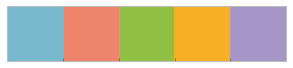

In [383]:
cmap = plt.get_cmap("Set3", 5)
clusters_colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    clusters_colors.append(mpl.colors.rgb2hex(rgb))
clusters_colors

clusters_colors=['#79b9ce', '#ef846d', '#8fc043', color_dict['y'], '#a596c7']
sns.palplot(clusters_colors)


In [ ]:
plt.style.use('bmh')
mpl.rcParams['axes.facecolor'] = 'white'
plt.rc('font', **{'size'   : 12})
plt.rcParams.update(params)
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[10,10], dpi=80)
plt.subplots_adjust(wspace=0.5)
# Choose 4 as the optimal value of k

for index, n in enumerate(list(range(2,6))):
    colors = clusters_colors[:n]
    km = KMeans(n_clusters = n,
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0)
    km.fit(rfm_scaled)
    rfm_clean['km_cluster'] = km.labels_
    sns.scatterplot(x='pc 1', y='pc 2', hue='km_cluster', data=rfm_clean, palette=colors, ax=ax[index, 0])
    #   ax[index, 0].set_title('k={:}'.format(n))
    ax[index, 0].set_ylabel('k={:}'.format(n), rotation=0, ha='right', labelpad=10)
    ax[index, 0].set_xlabel('')
    ax[index, 0].legend().remove()
    rfm_scaled_mean = pd.DataFrame(rfm_scaled, columns=['R','F','M'])
    rfm_scaled_mean['km_cluster'] = km.labels_
    rfm_scaled_mean = rfm_scaled_mean.groupby('km_cluster').mean().reset_index()
    parallel_coordinates(rfm_scaled_mean, 'km_cluster', ax=ax[index,1], color=colors)
    ax[index, 1].legend().remove()
    sns.countplot(rfm_clean['km_cluster'], palette=colors, ax=ax[index,2])
    ax[index, 2].set_ylabel('')
    ax[index, 2].set_xlabel('')
    change_width(ax[index, 2], .6)

for col, title in enumerate(['Separation', 'Differentiation', 'Distribution']):
    ax[0,col].set_title(title, rotation=0, y=1.1)


#fig.suptitle('The Evaluation of K', fontsize=20, color='#595959', y=1.1)

plt.tight_layout()   
plt.savefig('The Evaluation of K', facecolor='white', bbox_inches="tight", dpi=80)

# Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [85]:
X, y = rfm_clean.iloc[:, :3], rfm_clean[['km_cluster']]
#X_train, X_test, y_train, y_test = train_test_split(rfm_clean.iloc[:, :3], rfm_clean[['km_cluster']], test_size=0.25, random_state=123)
train_score = []
#test_score = []
for i in range(2,11,2):
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X,y)
    train_score.append(tree.score(X,y))
#    test_score.append(tree.score(X_test, y_test))
#    print('max_depth= ', i)
#    print('train score', tree.score(X_train, y_train))
 #   print('test score', tree.score(X_test, y_test))
  #  print('\n')

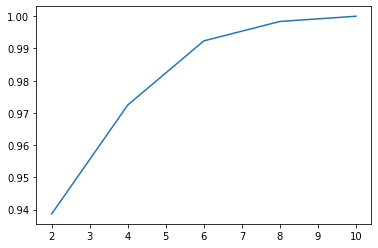

In [87]:
sns.lineplot(x=np.arange(2,11,2), y=train_score)
#sns.lineplot(x=np.arange(2,11,2), y=test_score)

In [90]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

0.9641975308641976

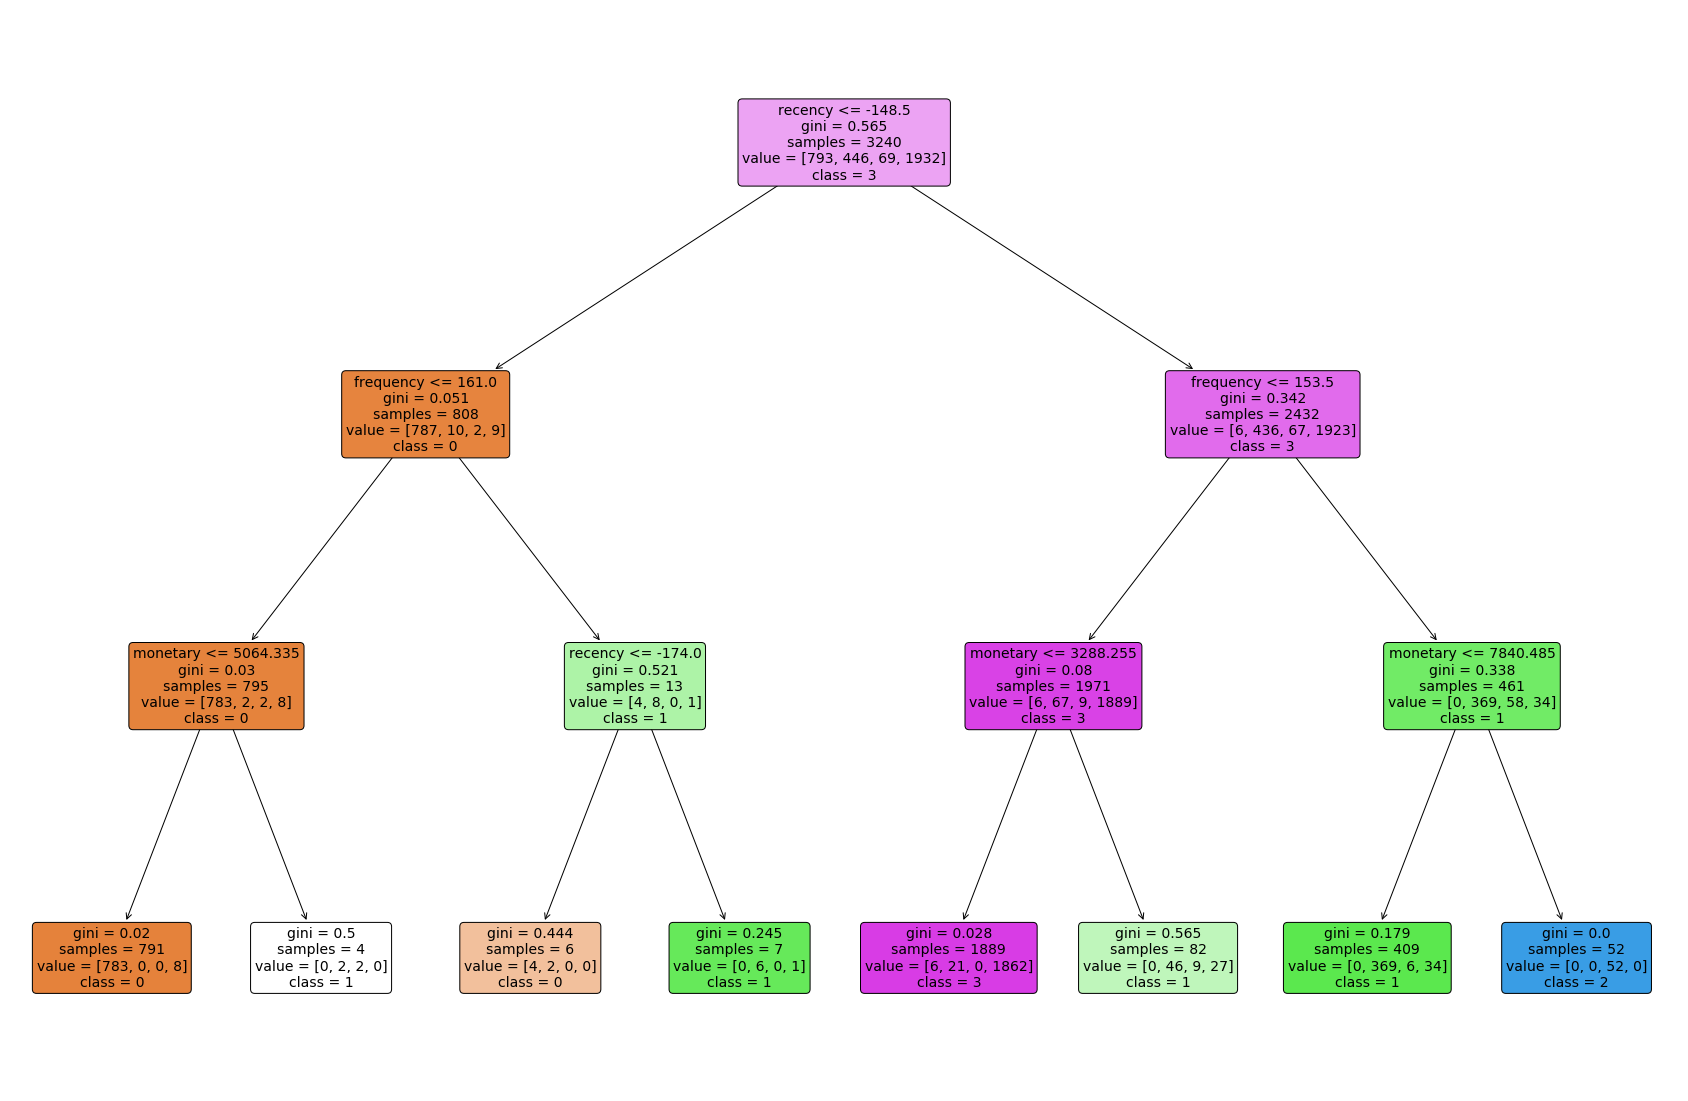

In [91]:
from sklearn.tree import plot_tree
plt.figure(figsize=[30,20])
plot_tree(tree, 
          feature_names=X_train.columns, 
          filled=True, 
          rounded=True, 
          fontsize=14,
          class_names=[str(i) for i in range(4)])
plt.show()

In [243]:
retail_with_clusters = pd.merge(rfm_clean.reset_index()[['CustomerID', 'km_cluster_label']], retail, on='CustomerID', how='left')

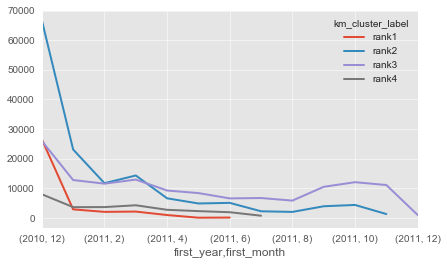

In [251]:
retail_with_clusters.groupby(['km_cluster_label','first_year', 'first_month'])['CustomerID'].count().unstack(level=0).plot()

In [227]:
retail_items_with_clusters = pd.merge(rfm_clean.reset_index()[['CustomerID', 'km_cluster_label']], retail_items.reset_index(), on='CustomerID', how='left')
retail_items_with_clusters.head()

,CustomerID,km_cluster_label,InvoiceNo,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,12346.0,rank4,541431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12346.0,rank4,C541433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12347.0,rank2,537626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12347.0,rank2,542237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12347.0,rank2,549222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [238]:
retail_items_with_clusters.loc[retail_items_with_clusters['km_cluster_label']=='rank1'].iloc[:,2:].mean().sort_values(ascending=False).head(10)

REGENCY CAKESTAND 3 TIER              0.127225
JUMBO BAG RED RETROSPOT               0.092922
LUNCH BAG RED RETROSPOT               0.087277
PARTY BUNTING                         0.084672
WHITE HANGING HEART T-LIGHT HOLDER    0.078159
POSTAGE                               0.074685
ASSORTED COLOUR BIRD ORNAMENT         0.071211
ALARM CLOCK BAKELIKE RED              0.063830
ROSES REGENCY TEACUP AND SAUCER       0.062093
SPOTTY BUNTING                        0.058185
dtype: float64

In [237]:
retail_items_with_clusters.loc[retail_items_with_clusters['km_cluster_label']=='rank2'].iloc[:,2:].mean().sort_values(ascending=False).head(10)

WHITE HANGING HEART T-LIGHT HOLDER    0.104412
JUMBO BAG RED RETROSPOT               0.095305
REGENCY CAKESTAND 3 TIER              0.081174
LUNCH BAG RED RETROSPOT               0.080546
ASSORTED COLOUR BIRD ORNAMENT         0.074423
PARTY BUNTING                         0.069085
LUNCH BAG  BLACK SKULL.               0.067672
SET OF 3 CAKE TINS PANTRY DESIGN      0.065316
ALARM CLOCK BAKELIKE RED              0.064688
LUNCH BAG SPACEBOY DESIGN             0.062176
dtype: float64

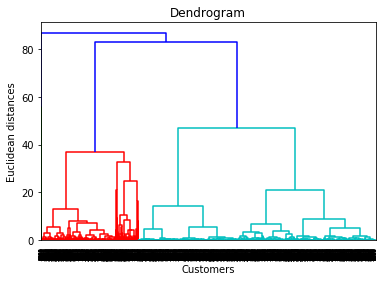

In [202]:
import scipy.cluster.hierarchy as sch
#Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on which data we apply and engage. This is X dataset
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [184]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(rfm)
tsne_clusters = pd.DataFrame(np.c_[tsne_results, labels], columns=['tsne_1','tsne_2','km_cluster'])
sns.scatterplot(x='tsne_1', y='tsne_2', hue='km_cluster', data=tsne_clusters)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [175]:
wss, sil = find_best_k(rfm_scaled)

Text(0, 0.5, 'Silhouette Score')

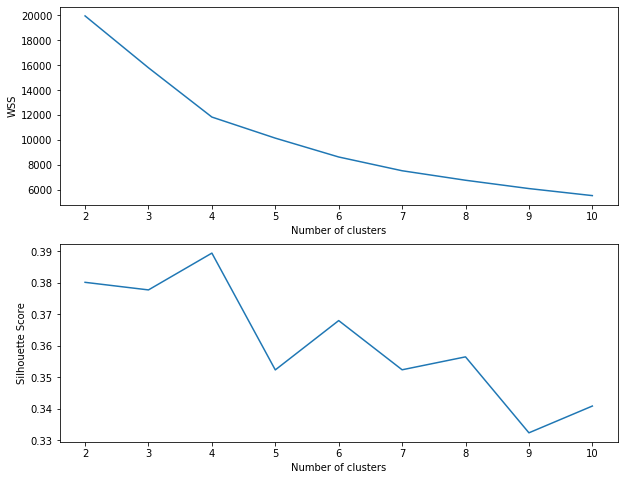

IndexError: too many indices for array

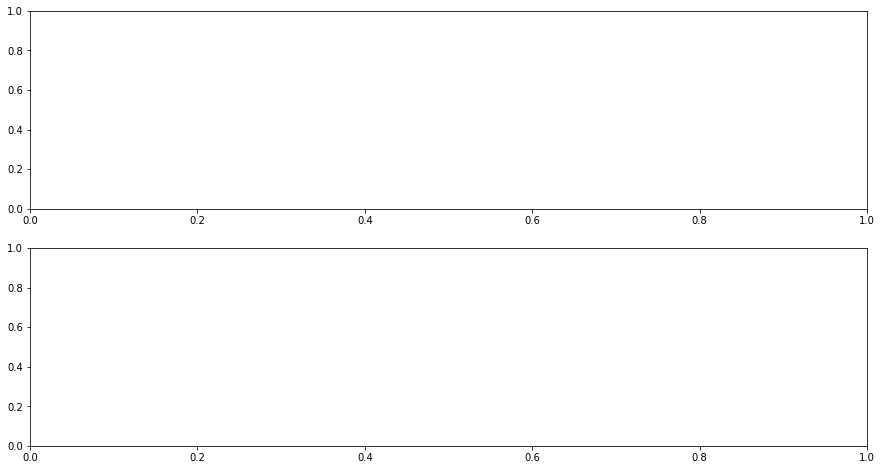

In [174]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15, 8])
for col in range(1):
    wss, sil = find_best_k(rfm_scaled)
    sns.lineplot(x=np.arange(2,11), y=wss, ax=ax[0, col])
    ax[0, col].set_xlabel('Number of clusters')
    ax[0, col].set_ylabel('WSS')
    sns.lineplot(x=np.arange(2,11), y=sil, ax=ax[1, col])
    ax[1, col].set_xlabel('Number of clusters')
    ax[1, col].set_ylabel('Silhouette Score')

In [109]:
rfm = retail.groupby('CustomerID')[['recency', 'frequency', 'monetary']].mean()
index = 1
col = rfm.columns[index]
km = KMeans(n_clusters = 4,
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0)
km.fit(rfm_scaled[:, index][:,None])
col_name = col +'_rank'
rfm[col_name] = km.labels_
#rfm[col_name] = 'label_' + rfm[col_name].astype('str')
#current_label = rfm.groupby(col_name)[col].mean().sort_values().index
#label_map = {current_label[new_label]:new_label for new_label in range(4)}
#rfm[col_name] = rfm[col_name].map(label_map)

In [111]:
rfm[col_name].value_counts()

0    3862
2     482
3      24
1       4
Name: frequency_rank, dtype: int64

In [105]:
for index, col in enumerate(rfm.columns):
    km = KMeans(n_clusters = 4,
                n_init=10, max_iter=300,
                tol=1e-04, random_state=0)
    km.fit(rfm_scaled[:, index][:,None])
    col_name = col +'_rank'
    rfm[col_name] = km.labels_
    rfm[col_name] = 'label_' + rfm[col_name].astype('str')
    current_label = rfm.groupby(col_name)[col].mean().sort_values().index
    label_map = {current_label[new_label]:new_label for new_label in range(4)}
    rfm[col_name] = rfm[col_name].map(label_map)


In [106]:
rfm.head()

,recency,frequency,monetary,recency_rank,frequency_rank,monetary_rank
CustomerID,,,,,,
12346.0,326,2,0.00,3,0,0
12347.0,3,182,4310.00,0,0,0
12348.0,76,31,1797.24,1,0,0
12349.0,19,73,1757.55,0,0,0
12350.0,311,17,334.40,3,0,0


In [100]:
rfm['rfm_score'] = rfm.iloc[:,3:6].sum(axis=1)
rfm.head()

,recency,frequency,monetary,recency_rank,frequency_rank,monetary_rank,rfm_score
CustomerID,,,,,,,
12346.0,326,2,0.00,3,0,0,3
12347.0,3,182,4310.00,0,3,3,6
12348.0,76,31,1797.24,1,2,2,5
12349.0,19,73,1757.55,0,3,3,6
12350.0,311,17,334.40,3,0,0,3


In [101]:
rfm.groupby('rfm_score').sum()

,recency,frequency,monetary,recency_rank,frequency_rank,monetary_rank
rfm_score,,,,,,
3,157053,11748,182044.250,1518,0,0
4,119341,21784,367209.521,1248,624,624
5,86518,56516,1042362.652,1064,2128,2128
6,41853,316781,6708449.391,0,6534,6534


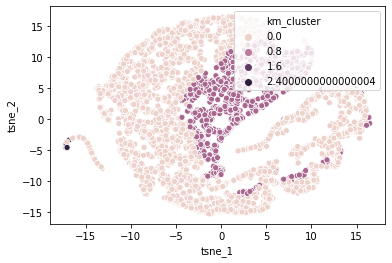

In [104]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,revenue,first_date,first_year,first_month,first_day,retain_months,recency,frequency,monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,15.30,2010-12-01 08:26:00,2010,12,1,1,-303,312,5288.63
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,20.34,2010-12-01 08:26:00,2010,12,1,1,-303,312,5288.63
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,22.00,2010-12-01 08:26:00,2010,12,1,1,-303,312,5288.63
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,20.34,2010-12-01 08:26:00,2010,12,1,1,-303,312,5288.63
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,20.34,2010-12-01 08:26:00,2010,12,1,1,-303,312,5288.63


In [8]:
retail[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


* Quanitiy and UnitPrice should not be negative. Besides, their maximum values are too large and it doen't make sense. Therefore, we should look at those weird values more closedly.

In [9]:
retail.loc[retail['Quantity'] < 0,:].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


* Among rows with negative quantity values, the first string of InvoiceNo is 'C'. 

In [159]:
retail.loc[(retail['Quantity'] < -10000) | (retail['Quantity'] > 10000) ,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


* When we examine those rows with unreasonable large quanitities, we can find that those rows have duplicate rows with the same but negative amount of quantity. Therefore, we can suggest that those rows with negative quantity are related to returns.
* However, we still should remove those rows with extreme large quantities. Obviously, they are outliers.

In [9]:
retail.loc[retail['UnitPrice'] > 10000,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098.0,United Kingdom


* The row with large UnitPrice are related to return stuff and we will drop this row later.

# Cohort Analysis

In [10]:
# Remove rows with negative or extreme large values of quantity
retail_new = retail.loc[(retail['Quantity'] > 0) & (retail['Quantity'] < 20000),:]

In [167]:
# Group by customers
retail_by_customer = retail_new.groupby(['CustomerID', 'InvoiceNo']).agg({'TotalAmount':'sum',
                                                                          'first_year':'mean',
                                                                          'first_month':'mean',
                                                                          'retain_month':'mean'})
retail_by_customer = retail_by_customer.reset_index()
retail_by_customer.head()
#retail_new.groupby('InvoiceNo')['TotalAmount'].transform('sum')

,CustomerID,InvoiceNo,TotalAmount,first_year,first_month,retain_month
0,12347.0,537626,711.79,2010,12,1
1,12347.0,542237,475.39,2010,12,2
2,12347.0,549222,636.25,2010,12,5
3,12347.0,556201,382.52,2010,12,7
4,12347.0,562032,584.91,2010,12,9


In [169]:
# Cohort Analysis
cohort_by_month = pd.pivot_table(retail_new, values='CustomerID', index=['first_year', 'first_month'],
                                 columns=['retain_month'], aggfunc='count')

In [186]:
cohort_by_month_percent = cohort_by_month.div(cohort_by_month.iloc[:,0], axis=0)
cohort_by_month_percent

retain_month             1         2         3         4         5         6   \
first_year first_month                                                          
2010       12           1.0  0.398471  0.341514  0.450573  0.376032  0.472095   
2011       1            1.0  0.215138  0.278708  0.214491  0.345794  0.299898   
           2            1.0  0.159073  0.218364  0.277656  0.249394  0.226900   
           3            1.0  0.126193  0.220656  0.210928  0.217020  0.187381   
           4            1.0  0.194922  0.179939  0.178829  0.189234  0.282741   
           5            1.0  0.180120  0.147098  0.148099  0.245497  0.389760   
           6            1.0  0.161656  0.128533  0.266607  0.304770  0.446265   
           7            1.0  0.100401  0.267134  0.273347  0.363527  0.105411   
           8            1.0  0.331515  0.597776  0.577004  0.188628       NaN   
           9            1.0  0.285922  0.320029  0.104862       NaN       NaN   
           10           1.0  0.306318  0.075660       NaN       NaN       NaN   
           11           1.0  0.101037       NaN       NaN       NaN       NaN   
           12           1.0       NaN       NaN       NaN       NaN       NaN   

retain_month                  7         8         9         10        11  \
first_year first_month                                                     
2010       12           0.440749  0.444878  0.444916  0.558639  0.533716   
2011       1            0.256871  0.269548  0.364764  0.463496  0.597946   
           2            0.249971  0.295767  0.332449  0.328181  0.046718   
           3            0.248932  0.317665  0.375125  0.086735       NaN   
           4            0.264428  0.303274  0.072558       NaN       NaN   
           5            0.319213  0.131755       NaN       NaN       NaN   
           6            0.109091       NaN       NaN       NaN       NaN   
           7                 NaN       NaN       NaN       NaN       NaN   
           8                 NaN       NaN       NaN       NaN       NaN   
           9                 NaN       NaN       NaN       NaN       NaN   
           10                NaN       NaN       NaN       NaN       NaN   
           11                NaN       NaN       NaN       NaN       NaN   
           12                NaN       NaN       NaN       NaN       NaN   

retain_month                  12        13  
first_year first_month                      
2010       12           0.862232  0.277638  
2011       1            0.136115       NaN  
           2                 NaN       NaN  
           3                 NaN       NaN  
           4                 NaN       NaN  
           5                 NaN       NaN  
           6                 NaN       NaN  
           7                 NaN       NaN  
           8                 NaN       NaN  
           9                 NaN       NaN  
           10                NaN       NaN  
           11                NaN       NaN  
           12                NaN       NaN

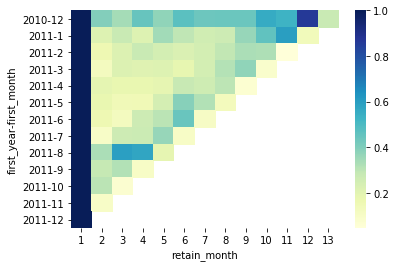

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cohort_by_month_percent, cmap="YlGnBu")
plt.show()

# Customer Segmentation

## Recency
To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [13]:
retail['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

### Set today as 2011-12-10

In [30]:
# Define a function to calculate how many days there are between two dates
from datetime import date
def date_diff(d1, d2):
    d1 = date.strftime(d1, "%Y-%m-%d")
    d2 = date.strftime(d2, "%Y-%m-%d")
    
    return d1-d2

In [35]:
pd.to_datetime('2011-12-10',)-retail['InvoiceDate'][0]

Timedelta('373 days 15:34:00')

In [45]:
.dt.strftime('%Y-%m-%d') - retail['InvoiceDate'].dt.strftime('%Y-%m-%d')

AttributeError: 'Timestamp' object has no attribute 'dt'

In [51]:
recency_df = retail.groupby('CustomerID')['InvoiceDate'].max().reset_index().rename(columns={'InvoiceDate':'LastPurchase'})

In [54]:
recency_df['today'] = pd.to_datetime('2011-12-10', format='%Y-%m-%d')

In [52]:
recency_df['LastPurchase'] = pd.to_datetime(recency_df['LastPurchase'], format='%Y-%m-%d')

In [55]:
recency_df['Recency'] = recency_df['today'] - recency_df['LastPurchase']
recency_df.head()

,CustomerID,LastPurchase,today,Recency
0,12346.0,2011-01-18 10:17:00,2011-12-10,325 days 13:43:00
1,12347.0,2011-12-07 15:52:00,2011-12-10,2 days 08:08:00
2,12348.0,2011-09-25 13:13:00,2011-12-10,75 days 10:47:00
3,12349.0,2011-11-21 09:51:00,2011-12-10,18 days 14:09:00
4,12350.0,2011-02-02 16:01:00,2011-12-10,310 days 07:59:00


In [57]:
recency_df['Recency'].day

AttributeError: 'Series' object has no attribute 'day'